# This is a notebook to explore the ligpy results after solving the ODE model

Model results are saved by DDASAC in the format shown in the `ligpy/sample_results/` folder.  
Users that rely on a different ODE solver should format their results in the same way in order to use these analysis tools.

In [1]:
# import os
import sys
import fnmatch
import copy
import csv

import numpy as np
import matplotlib.pyplot as plt           
import ipywidgets as widgets

import ligpy.ligpy_utils as utils
from ligpy.constants import MW
from ligpy.analysis_tools import load_results, tar_elem_analysis, C_fun_gen
from ligpy.analysis_tools import lump_species, generate_report

%matplotlib inline


### Choose the simulation results to analyze in this notebook

Users should specify the directory where their results are saved as a string object named `results_dir`.  
Then, select the folder you would like to analyze in this notebook by clicking it in the selection box.

In [2]:
# Absolute or relative path to the directory you've saved model results in
results_dir = 'ligpy/sample_results/'

results = !ls $results_dir
which_result = widgets.Select(options=results)
which_result

## Load the results from the chosen folder and generate a descriptive summary

In [3]:
# Load the program parameters and results from the selected folder
(end_time, output_time_step, initial_T, heating_rate, max_T, atol, rtol,
 plant, cool_time, y, t, T, specieslist, speciesindices,
 indices_to_species) = load_results(results_dir + which_result.value)

# If you want to make sure all species are present in the MW dictionary run this
# utils.check_species_in_MW(specieslist)

# create a new matrix of mass fractions (instead of concentrations)
m = copy.deepcopy(y)
for species in specieslist:
    # make an array of mass concentration (g/L)
    m[:, speciesindices[species]] = (y[:, speciesindices[species]] *
                                     MW[species][0])
# total mass at time 0
m_0 = m[0,:].sum(axis=0)
# The mass fractions
m /= m_0
# These two numbers should both be 1 if mass is conserved.  We know that some
# protons are not tracked in the model so this number should be close to 1
print '\nIf mass is conserved %s should equal %s\n'\
        % (m[0,:].sum(axis=0),m[-1,:].sum(axis=0))
    
generate_report(speciesindices, specieslist, y, m, t, which_result)

There is not a third DDASAC results file (cool down period)

If mass is conserved 1.0 should equal 0.998289709349


------------------------------------ REPORT ------------------------------------
Analysis of folder: Pinus_ponderosa-max973K-15.0CperMin-2760.0end-0cool
Analysis done at the end of the entire simulation.

.............................. Elemental Analysis ..............................

Feedstock (wt%)  : 62.7% C    5.7% H   31.6% O
Bio-oil (wt%)    : 53.4% C    7.6% H   39.0% O

Feedstock (mol%) : 40.5% C   44.2% H   15.3% O
Bio-oil (mol%)   : 30.8% C   52.3% H   16.9% O

H:C ratio of tar = 1.7

Moisture content of tar (wt%) = 15.0%

............ Distribution of C-functional groups (shown as % of C) .............

                   Feedstock       Bio-oil         Heavy oil       Light oil       
C=O                3.62%           11.26%          8.37%           23.11%          
aromatic C-O       26.33%          18.69%          22.26%          4.06%           
aromatic C

### min/max mass fractions or concentrations for every species 
Un-comment out the appropriate block in this cell to see these reports

In [4]:
# # Concentrations
# print ('{0: <8}'.format('Species') + '\t' +
#        '{0: <14}'.format('Min Conc') + '\tMax Conc\n')
# for species in specieslist:
#     if np.nanmax(y[:, speciesindices[species]]) > 1e-5:
#         print ('%s\t%s\t%s' %
#                ('{0: <8}'.format(species),
#                 '{0: <14}'.format(np.nanmin(y[:, speciesindices[species]])),
#                 np.nanmax(y[:, speciesindices[species]])))

# # Mass fractions
# print ('{0: <8}'.format('Species') + '\t' +
#        '{0: <18}'.format('Min Mass Frac') + '\tMax Mass Frac\n')
# for species in specieslist:
#     if np.nanmax(m[:, speciesindices[species]]) > 1e-5:
#         print ('%s\t%s\t%s' % 
#                ('{: <8}'.format(species),
#                 '{: <18.2}'.format(np.nanmin(m[:, speciesindices[species]])),
#                 '{:}'.format(np.nanmax(m[:, speciesindices[species]]))))

## Visualizing the data
Here are some simple plots to start exploring the results

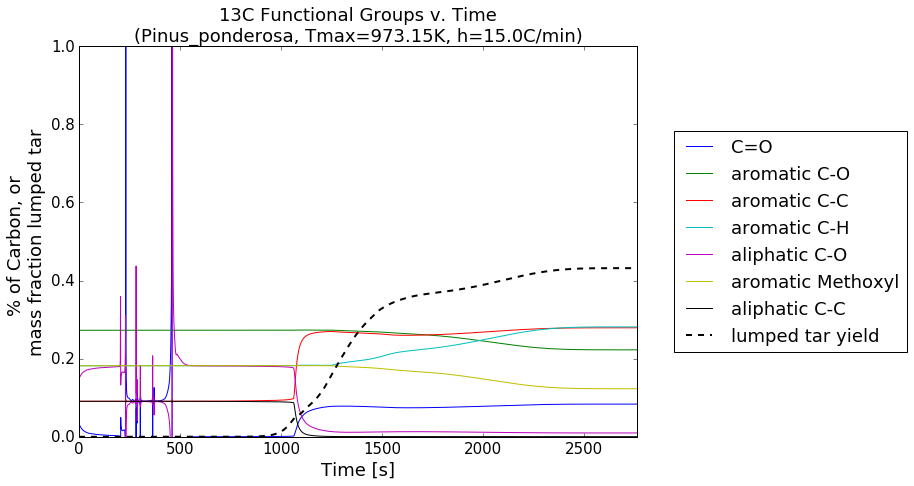

In [11]:
# Mass fraction of each 13C functional group vs. time
groups = ['C=O', 'aromatic C-O', 'aromatic C-C', 'aromatic C-H',
              'aliphatic C-O', 'aromatic Methoxyl', 'aliphatic C-C']
morelumped = lump_species(speciesindices, m)[2]
C13_array = np.zeros([7, len(t)])
for i, time in enumerate(t):
    C13_array[:, i] = C_fun_gen(['t'],speciesindices, y, time[0])
C13_array = np.nan_to_num(C13_array)

plt.figure(figsize=(10,7), dpi=200)
for i in range(0, len(groups), 1):
    plt.plot(t[:], C13_array[i, :], label=groups[i])
    
# Add a line for the total lumped tar yield
plt.plot(t[:], morelumped[:, 1], label='lumped tar yield', color='black',
         linestyle='--', linewidth=2.0)

plt.axis([0, t[-1], 0, 1])
plt.xlabel('Time [s]', fontsize=18)
plt.ylabel('% of Carbon, or \nmass fraction lumped tar', fontsize=18)
plt.title('13C Functional Groups v. Time\n(%s, Tmax=%sK, h=%sC/min)' % 
          (plant, max_T, heating_rate), fontsize=18)
plt.legend(ncol=1, loc='center left', bbox_to_anchor=(1.05, 0.5), fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15);

In [ ]:
last_t = t[-1]
last_t_position = len(t)
# convert temperature from K to C
Temperature = T - 273.15

